In [1]:
import numpy as np
import os
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import curve_fit
from scipy import interpolate, integrate
from skspatial.objects import Sphere
import glob
import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D


plt.style.use('light_mode')
%matplotlib inline

In [2]:
DATA_DIR = '/Users/darbymccauley/coursework/ast503_2024_Fall/homework/darby_mccauley/data/hw2_data/'

In [3]:
def color_gen(N, cmap):
    """
    Inputs:
        - N (int): Number of points to sample the colormap with
        - cmap (str): colormap to sample from
    Returns: array of colors (r,g,b,alpha)
    """
    colormap = plt.get_cmap(cmap)
    colors = colormap(np.linspace(0,1, N))
    return (colormap, colors)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).


I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
c = (3e5 * (u.km/u.s)).to(u.micrometer/u.s)

Z_SPACING = 0.25
zs = np.arange(1, 8 + Z_SPACING, Z_SPACING)

common_bands = np.array([160, 200, 350, 450, 500, 850, 1100, 1400, 2100]) * u.micrometer

In [5]:
data = at.Table.read(os.path.join(DATA_DIR, 'aless_average_seds.dat'), 
                     format='ascii', 
                     names=['wave', 'fnu', 'fnu_bright', 'fnu_faint'], 
                     data_start=1)
wave_sed, flux_sed  = data['wave'] * u.micrometer, data['fnu'] * u.mJy
WAVE_SPACING = 0.5 * u.micrometer
waves = np.arange(wave_sed.value.min(), wave_sed.value.max() + WAVE_SPACING.value, WAVE_SPACING.value) * u.micrometer
freqs_sed = c / wave_sed
freqs = c / waves

In [6]:
def sed_interp(wave, flux, spacing=0.5, freq_space=True): # input wave_sed, flux_sed, each redshifted
    interp_wave = waves
    interp_nu = c / interp_wave 
    interp_func = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0.0)
    interp_flux_nu = interp_func(interp_wave) * u.mJy
    interp_flux_wave = interp_flux_nu * (interp_nu**2 / c)
    if freq_space:
        return interp_nu, interp_flux_nu
    else:
        return interp_wave, interp_flux_wave

def redshift_sed(wave, flux_nu, z):
    rwave = wave * (1 + z)
    rnu = c / rwave
    const = 10 * u.pc
    normf = ( const / cosmo.luminosity_distance(z).to(u.pc) )**2
    rflux_nu = flux_nu * normf * (1 + z)
    rflux_wave = flux_nu * (rnu**2 / c) * normf * (1 + z)
    return rwave, rnu, rflux_wave, rflux_nu

def gen_band(waves, band_center, BW=3):
    band = np.zeros_like(waves)
    res = np.abs(waves - band_center)
    idx = res.argmin()
    band[idx - BW:idx + BW] = 1
    return band

def kcorrection(wave_sed, flux_sed, z, Rband):
    freqs_sed = c / wave_sed
    A = (1 + z)
    Rband_prime = interpolate.interp1d(freqs_sed * A, Rband, bounds_error=False, fill_value=0.0)(freqs_sed)
    Areas = []
    for l in lsst.keys():
        prod = Rband_prime * lsst[l]['interp'](freqs_sed)
        area = np.sum(prod)
        Areas.append(area)
    if np.max(Areas) == 0.0:
        return np.nan
    else:
        idx_max = np.argmax(Areas) # which ugrizy band overlaps the most
        Qband = list(lsst.keys())[idx_max] # get that band's name
        rwave, rnu, rflux_wave, rflux_nu = redshift_sed(wave_sed, flux_sed, z) # redshift sed
        
        # Compute the integrals
        t1 = np.sum(rflux_nu * Rband / rnu)
        t2 = np.sum(lsst[Qband]['interp'](freqs_sed) / freqs_sed)
        t3 = np.sum(Rband / rnu)
        t4 = np.sum(rflux_nu * lsst[Qband]['interp'](freqs_sed) / freqs_sed)
    
        return -2.5 * np.log10(A * ( t1 * t2 ) / ( t3 * t4))

In [7]:
bandnames = ['95', '150', '220']
bicep = {}
bicep_files = sorted(glob.glob(os.path.join(DATA_DIR, 'BICEP*')))
for i, file in enumerate(bicep_files):
    d = at.Table.read(file, format='ascii', names=['wave', 'trans'])
    bicep[bandnames[i]] = {}
    bicep[bandnames[i]]['wave'] = (d['wave'] * u.Angstrom).to(u.micrometer)
    bicep[bandnames[i]]['trans'] = d['trans']

In [8]:
lsst = {}
lsst_files = glob.glob(os.path.join(DATA_DIR, 'LSST*'))
for i, file in enumerate(lsst_files):
    filter_name = os.path.basename(file)[10] # get filter name (ugrizy)
    lsst[filter_name] = {}
    df = np.loadtxt(file)
    x, y = (df[:,0]*u.angstrom).to(u.Hz, equivalencies=u.spectral()), df[:,1] # frequency [Hz], transmission
    lsst[filter_name]['raw'] = np.array([x,y])
    interp_filter = interpolate.interp1d(x, y, bounds_error=False, fill_value=0.0)
    lsst[filter_name]['interp'] = interp_filter

In [9]:
flux_z = []
for cb in common_bands:
    fs = []
    band = gen_band(waves.value, cb.value)
    for z in zs:
        rwave, _, _, rflux_nu = redshift_sed(wave_sed, flux_sed, z)
        _, interp_rflux_wave = sed_interp(rwave, rflux_nu, spacing=0.5, freq_space=True)
        f = np.sum(band * (interp_rflux_wave.value * waves.value))
        fs.append(f / 2e4) # 2e4 is a correction value for units
    flux_z.append(fs)
flux_z = np.array(flux_z)

/Users/darbymccauley/coursework/ast503_2024_Fall/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/darbymccauley/coursework/ast503_2024_Fall/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


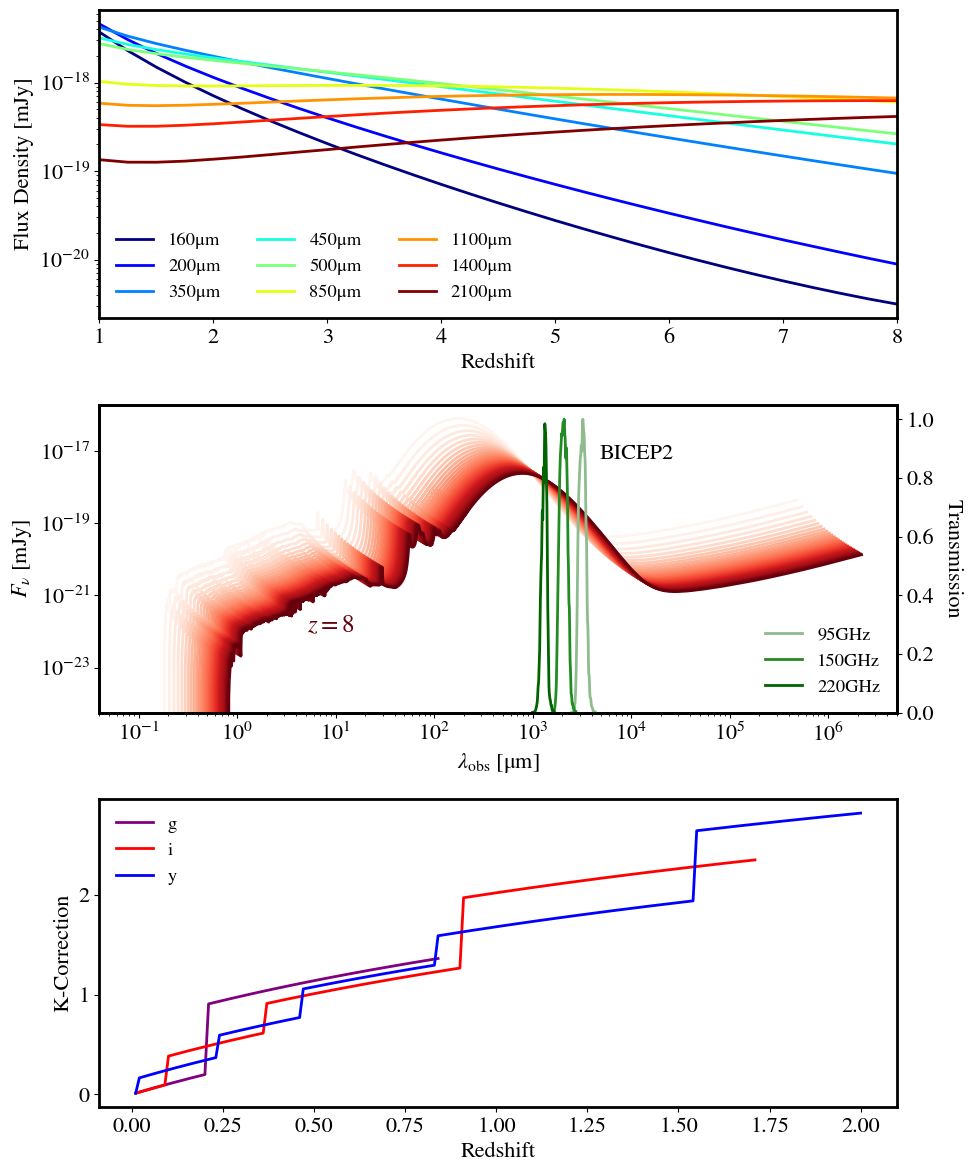

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)

###### ----------------- FIGURE 1 ----------------- ######

cmap, colors = color_gen(len(common_bands), 'jet')
for i, f in enumerate(flux_z):
    axes[0].plot(zs, f, color=colors[i], label=f'{int(common_bands[i].value)}μm', lw=2)
axes[0].set_xscale('linear')
axes[0].set_yscale('log')
axes[0].set_ylabel('Flux Density [mJy]')
axes[0].set_xlabel('Redshift')
axes[0].legend(loc="lower left", ncol=len(common_bands)/3)
# axes[0].legend(bbox_to_anchor=(1,1))
axes[0].set_xlim(zs.min(), zs.max())


###### ----------------- FIGURE 2 ----------------- ######

cmap, colors = color_gen(len(zs), 'Reds')
for i, z in enumerate(zs):
    rwave, _, _, rflux_nu = redshift_sed(wave_sed, flux_sed, z)
    axes[1].plot(rwave, rflux_nu, color=colors[i], lw=2)
axes[1].text(0.32, 0.32, r'$z=8$', horizontalalignment='right',
             verticalalignment='top', transform=axes[1].transAxes, fontsize=18, color=colors[-1])

axes01 = axes[1].twinx()
colors = ['darkseagreen', 'forestgreen', 'darkgreen']
for k, key in enumerate(bicep.keys()):
    axes01.plot(bicep[key]['wave'], bicep[key]['trans'], color=colors[k], label=key+'GHz', lw=2)
axes[1].text(0.72, 0.87, 'BICEP2', horizontalalignment='right',
             verticalalignment='top', transform=axes[1].transAxes, fontsize=16, color='k')
axes01.set_ylabel('Transmission', rotation=-90, labelpad=20)
axes01.set_ylim(0, 1.05)
axes01.legend(loc='lower right')

axes[1].set_ylabel(r'$F_ν$ [mJy]')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel(r'$λ_\mathrm{obs}$ [μm]')
axes[1].set_xlim(4e-2, 5e6)


###### ----------------- FIGURE 3 ----------------- ######
kzs = np.arange(0, 2 + 0.01, 0.01)
primebands = ['g', 'i', 'y']
# cmap, colors = color_gen(len(primebands), 'viridis')
colors = ['purple', 'r', 'b']
for i, pb in enumerate(primebands):
    ks = -1 * np.array([kcorrection(wave_sed.value, flux_sed.value, z, lsst[pb]['interp'](freqs_sed.value)) for z in kzs])
    axes[2].plot(kzs, ks, label=pb, color=colors[i], lw=2)
axes[2].legend()
axes[2].set_xlabel('Redshift')
axes[2].set_ylabel('K-Correction')

fig.tight_layout()
plt.show()


# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

In [11]:
MEAN_ABS_MAG = -19 
ABS_MAG_STD = 1 
BRIGHTNESS_LIMIT = 21 # cannot see SN with brightness >21
RADIUS = 2500 * u.Mpc
H0 = 72 * (u.km/u.s/u.Mpc)
VELOCITY_STD = 600 * (u.km/u.s)
NSAMPLES = [100, 1000, 10000]

class SuperNovae_Sim:
    
    def __init__(self, N=100, mean_abs_mag=MEAN_ABS_MAG, std_abs_mag=ABS_MAG_STD,
                 detection_threshold=BRIGHTNESS_LIMIT, radius=RADIUS,
                 H0=H0, peculiar_std=VELOCITY_STD):
        self.N = N
        self.mean_abs_mag = mean_abs_mag
        self.std_abs_mag = std_abs_mag
        self.detection_threshold = detection_threshold
        self.radius = radius
        self.H0 = H0
        self.peculiar_std = peculiar_std

        self.distance, self.coords = self.gen_sn_pos()
        self.mean_distance = self.mean_distance(self.distance)
        self.hubble_velocity = self.hubble_velocity(self.distance)
        self.peculiar_velocity = self.peculiar_velocity()
        self.total_velocity = self.hubble_velocity + self.peculiar_velocity
        self.abs_mags = self.gen_abs_mags()
        self.app_mags = self.apparent_magnitude(self.abs_mags, self.distance)
        self.detectable, self.undetectable = self.gen_rejected_sample()
        self.observed_distance = self.observed_distance(self.app_mags)        
        
        
    def peculiar_velocity(self):
        return np.random.normal(0, self.peculiar_std.value, self.N) * (u.km/u.s)

    def hubble_velocity(self, d):
        v = H0 * d
        return v.to(u.km/u.s)

    def gen_sn_pos(self):
        r = (np.random.uniform(0, 1, self.N))**(1/3) * self.radius
        θ = np.arccos(2*np.random.uniform(0, 1, self.N) - 1)
        ϕ = np.random.uniform(0, 2*np.pi, self.N)
        x = r * np.sin(θ) * np.cos(ϕ)
        y = r * np.sin(θ) * np.sin(ϕ)
        z = r * np.cos(θ)
        position = (x,y,z) 
        distance = np.sqrt(x**2 + y**2 + z**2)
        return distance, position

    def mean_distance(self, distance):
        return np.mean(distance)

    def gen_abs_mags(self):
        abs_mags = self.mean_abs_mag + np.random.normal(0, self.std_abs_mag, self.N)
        return abs_mags

    def apparent_magnitude(self, M, d):
        d = d.to(u.pc)
        m = 5 * np.log10(d.value) - 5 + M
        return m

    def gen_rejected_sample(self):
        detectable = np.argwhere(self.app_mags < self.detection_threshold)
        all_indices = np.arange(len(self.app_mags))
        undetectable = np.setdiff1d(all_indices, detectable)
        return detectable, undetectable
    
    def observed_distance(self, m):
        dl = 10**((m - self.mean_abs_mag + 5) / 5) * u.pc
        return dl.to(u.Mpc)
    
    def line(self, x, m, b):
        return m*x + b
    
    def linear_fit(self, xdata, ydata):
        pars, cov = curve_fit(sim.line, xdata, ydata)
        err = np.sqrt(np.diag(cov))
        return pars, err

    def plot_3d_space(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        center = [0, 0, 0]
        sphere = Sphere(center, self.radius)
        sphere.plot_3d(ax, alpha=0.2, color='grey')
        sphere.point.plot_3d(ax, s=50, marker='x', color='k')
        ax.scatter(*self.coords, color='r')
        plt.show()

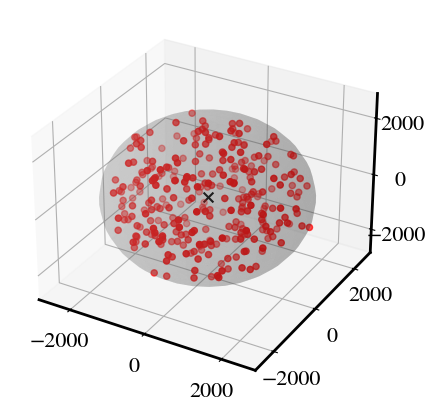

In [12]:
sim = SuperNovae_Sim(N=300)
sim.plot_3d_space()

----------------- N = 100 -----------------
Mean distance to supernovae: 1802.98 Mpc
Average magnitude (original sample): 22.15
Average magnitude (detected sample): 20.16

----------------- N = 1000 -----------------
Mean distance to supernovae: 1868.63 Mpc
Average magnitude (original sample): 22.31
Average magnitude (detected sample): 20.29

----------------- N = 10000 -----------------
Mean distance to supernovae: 1861.15 Mpc
Average magnitude (original sample): 22.23
Average magnitude (detected sample): 20.22



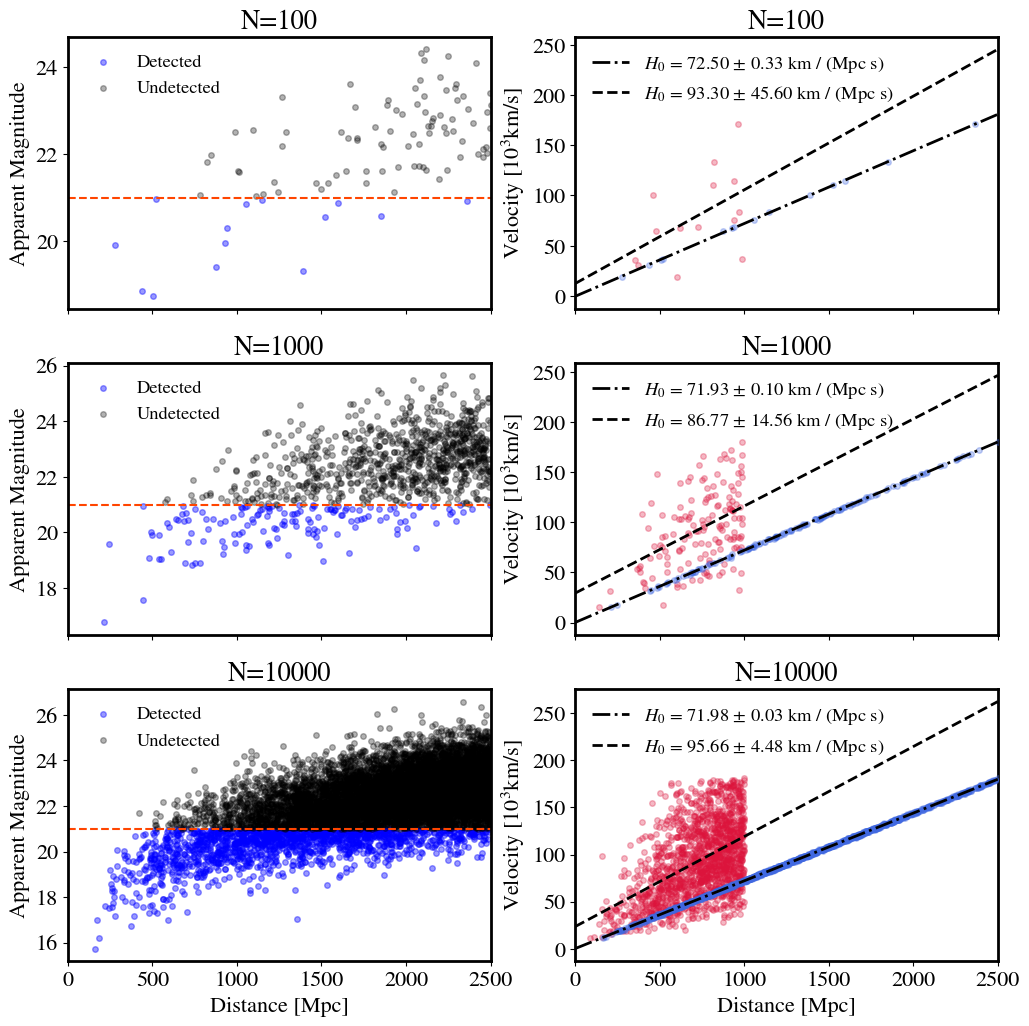

In [13]:
fig, axes = plt.subplots(3,2, figsize=(12,12), sharex=True)

for i, N in enumerate(NSAMPLES):
    sim = SuperNovae_Sim(N=N)
    print(f'----------------- N = {sim.N} -----------------')
    print(f'Mean distance to supernovae: {sim.mean_distance:.2f}')
    print(f'Average magnitude (original sample): {np.mean(sim.app_mags):.2f}')
    print(f'Average magnitude (detected sample): {np.mean(sim.app_mags[sim.detectable]):.2f}\n')
    
    xs = np.linspace(0, sim.radius.value)

    axes[i,0].scatter(sim.distance[sim.detectable], sim.app_mags[sim.detectable], marker='.', color='b', alpha=0.4, label='Detected')
    axes[i,0].scatter(sim.distance[sim.undetectable], sim.app_mags[sim.undetectable], marker='.', color='k', alpha=0.3, label='Undetected')
    axes[i,0].hlines(sim.detection_threshold, 0, sim.radius.value, ls='dashed', color='orangered')
    axes[i,0].set_ylabel('Apparent Magnitude')
    axes[i,0].set_xlim(0, sim.radius.value)
    axes[i,0].set_title(f'N={sim.N}')
    axes[i,0].legend()

    axes[i,1].plot(sim.distance[sim.detectable], sim.total_velocity[sim.detectable] / 1e3, '.', color='royalblue', alpha=0.3, zorder=3)
    fit = sim.linear_fit(sim.distance[sim.detectable].value.flatten(), sim.total_velocity[sim.detectable].value.flatten())
    axes[i,1].plot(xs, sim.line(xs, *fit[0]) / 1e3, color='k', ls='dashdot', 
                 zorder=10, lw=2, label=r'$H_0$ = {0:.2f} $\pm$ {1:.2f} {2}'.format(fit[0][0], fit[1][0], u.km/u.s/u.Mpc))
    
    axes[i,1].plot(sim.observed_distance[sim.detectable], sim.total_velocity[sim.detectable] / 1e3, '.', color='crimson', alpha=0.3)
    fit = sim.linear_fit(sim.observed_distance[sim.detectable].value.flatten(), sim.total_velocity[sim.detectable].value.flatten())
    axes[i,1].plot(xs, sim.line(xs, *fit[0]) / 1e3, color='k', ls='dashed', lw=2, 
                 zorder=10, label=r'$H_0$ = {0:.2f} $\pm$ {1:.2f} {2}'.format(fit[0][0], fit[1][0], u.km/u.s/u.Mpc))
    
    axes[i,1].set_ylabel('Velocity [$10^3$km/s]')
    axes[i,1].set_title(f'N={sim.N}')
    axes[i,1].legend()

axes[2,0].set_xlabel('Distance [Mpc]')
axes[2,1].set_xlabel('Distance [Mpc]')


plt.show()

For each panel on the right, the red dots denote the case where all SN have the same instrinsic luminosity, and therefore an apparent magnitude of M=-19 with no spread in that magnitude. However, this is not physical. The more realistic case is overplotted by the blue dots, where the SN have magnitude spread. We see that the measured value of Hubble's constant varies widely between the two cases, with the red dots producing an H0 value much higher than the known value. This effect is occuring because we are taking the spread of the red dots to be very large ($\pm$ 1 order of magnitude). This spread causes our data to be heavily skewed to lower distances with higher velocities, making the slope, and hence our measurement of H0, steaper. This effect is the result of Malmquist's bias, which describes a systematic bias where brighter objects are favored. We are only likely to detect a SN that is far away if it is exceptionally bright. This sways our observed distance, where the distance to the SN appears shorter than its actual, true distance, hence skewing the data to smaller distances and higher velocities. Malmquist's bias gets stronger as the spread increases (see figure below). 

The sharp cut-off at ~1000 Mpc is the result of our choice of absolute magnitude for each SN. The cut-off point varies with values of M (see figure below), where the cut-off distance gets smaller as the SN get fainter, and vice versa.

The reader might notice that the measured value for Hubble's constant does decrease as the number of samples gets better. But this does not mean that Malmquist's bias can be avoided by taking more samples. Rather, there are two sources of bias in our fitting process: undersampling bias and Malmquist's bias. The first measured value of H0 is very high and has a large error attached to it. As the sample size increases, H0 and it's error decrease. This is because increasing the number of samples helps to knock down the undersampling issue. However, when N=1000, H0 still does not converge to the known value of 72 km/s/Mpc. This is because the dominating bias is now Malmquist's bias, which is independed of the number of samples we take. We can never eliminate Malmquist's bias by continuing to take more and more samples. This bias will continue to greatly skew the data regardless of the sample size, as shown above.

Divisional factor = 1, H0 = 92.86 +/- 13.28 km/s/Mpc
Divisional factor = 2, H0 = 80.53 +/- 8.84 km/s/Mpc
Divisional factor = 10, H0 = 72.37 +/- 2.08 km/s/Mpc
Divisional factor = 100, H0 = 72.11 +/- 0.57 km/s/Mpc


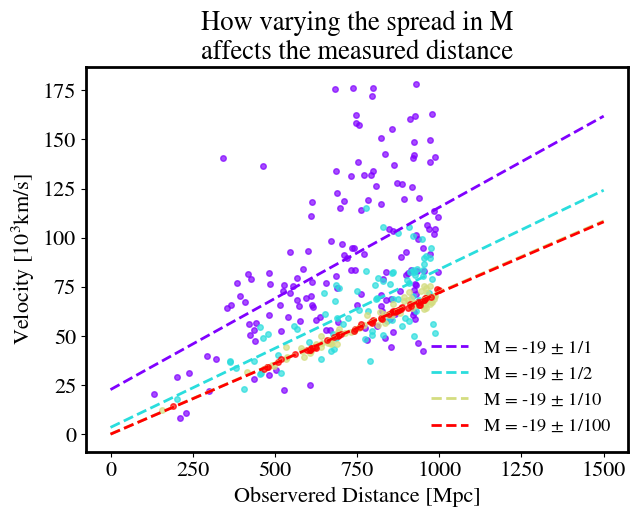

In [14]:
DIVISIONAL_FACTOR = [1, 2, 10, 100]
cmap, colors = color_gen(len(DIVISIONAL_FACTOR), 'rainbow')
xs = np.linspace(0, 1500)

fig, ax = plt.subplots(1,1) 
for i, f in enumerate(DIVISIONAL_FACTOR):
    sim = SuperNovae_Sim(N=1000, std_abs_mag=ABS_MAG_STD/f)
    ax.plot(sim.observed_distance[sim.detectable], sim.total_velocity[sim.detectable] / 1e3, '.', alpha=0.7, color=colors[i])
    fit = sim.linear_fit(sim.observed_distance[sim.detectable].value.flatten(), sim.total_velocity[sim.detectable].value.flatten())
    print(f'Divisional factor = {f}, H0 = {fit[0][0]:.2f} +/- {fit[1][0]:.2f} km/s/Mpc')
    ax.plot(xs, sim.line(xs, *fit[0]) / 1e3, ls='dashed', lw=2, color=colors[i],
                 zorder=10, label=r'M = {0} $\pm$ 1/{1}'.format(MEAN_ABS_MAG, f))
ax.legend()
ax.set_title('How varying the spread in M\naffects the measured distance')
ax.set_ylabel('Velocity [$10^3$km/s]')
ax.set_xlabel('Observered Distance [Mpc]')

plt.show()

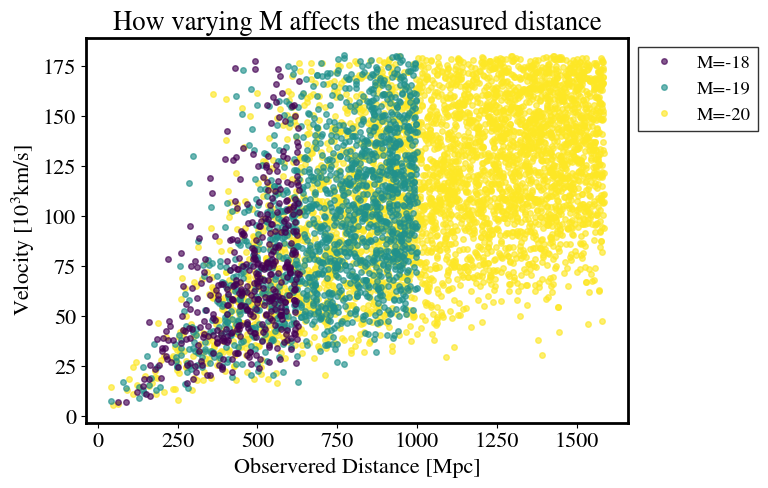

In [15]:
DIVISIONAL_FACTOR = 1
ABS_MAGS = [-18, MEAN_ABS_MAG, -20]
cmap, colors = color_gen(len(ABS_MAGS), 'viridis')
xs = np.linspace(0, 2000)

fig, ax = plt.subplots(1,1) 
for i, m in enumerate(ABS_MAGS):
    sim = SuperNovae_Sim(N=10000, mean_abs_mag=m, std_abs_mag=ABS_MAG_STD/DIVISIONAL_FACTOR)
    ax.plot(sim.observed_distance[sim.detectable], sim.total_velocity[sim.detectable] / 1e3, '.', alpha=0.65, color=colors[i], zorder=-i, label=f'M={m}')
ax.legend(bbox_to_anchor=(1,1), frameon=True, edgecolor='k')
ax.set_title('How varying M affects the measured distance')
ax.set_ylabel('Velocity [$10^3$km/s]')
ax.set_xlabel('Observered Distance [Mpc]')

plt.show()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!